In [1]:
import json
import spacy
import re

from tqdm import tqdm_notebook
import pandas as pd 

from collections import Counter

import matplotlib.pyplot as plt

from numpy.random import rand

from random import sample

In [2]:
import seaborn as sns

In [3]:
nlp = spacy.load('en')

In [4]:
f = open('./pytorch-pretrained-BERT/wrond_id_BERT.txt','rt')
wrong_bert = f.readlines()
f.close()

In [5]:
f = open('./pytorch-pretrained-BERT/wrond_id_DOCQA.txt','rt')
wrong_docqa = f.readlines()
f.close()

In [6]:
f = open('./pytorch-pretrained-BERT/wrond_id_BiDAF.txt','rt')
wrong_bidaf = f.readlines()
f.close()

In [7]:
f = open('./pytorch-pretrained-BERT/wrond_id_XLNet.txt','rt')
wrong_xlnet = f.readlines()
f.close()

In [8]:
def removen(file):
    return [line.rstrip('\n') for line in file]

In [9]:
wrong_bert = removen(wrong_bert)
wrong_docqa = removen(wrong_docqa)
wrong_bidaf = removen(wrong_bidaf)
wrong_xlnet = removen(wrong_xlnet)

In [10]:
wrong_bert = set(wrong_bert)
wrong_docqa = set(wrong_docqa)
wrong_bidaf = set(wrong_bidaf)
wrong_xlnet = set(wrong_xlnet)

In [11]:
rc_wrong = wrong_bert | wrong_docqa | wrong_bidaf | wrong_xlnet

In [12]:
all_wrong = wrong_bert & wrong_docqa & wrong_bidaf & wrong_xlnet

In [13]:
len(rc_wrong), len(all_wrong)

(4951, 653)

In [14]:
f = open('./pytorch-pretrained-BERT/squad/dev-v1.1.json','rb')
data = json.load(f)

In [15]:
data = data['data']

In [16]:
all_qid = []

In [17]:
len_squad = []
qcnt = 0
for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            len_squad.append(len(qas['question'].split()))
            qcnt += 1

In [43]:
len(all_qid)

10570

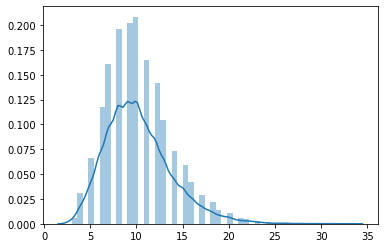

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib
sns.distplot(len_squad)

In [19]:
sum(len_squad)/qcnt

10.216650898770103

In [18]:
for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            all_qid.append(qas['id'])

In [19]:
len(all_qid)

10570

In [20]:
right_qid = set(all_qid)-set(all_wrong)

In [23]:
len(all_qid)

10570

In [24]:
len(right_qid), len(all_wrong)

(9917, 653)

In [25]:
print(sample(rc_wrong,20)) 

['57267b65dd62a815002e86a9', '572909ebaf94a219006a9fc8', '57339ad74776f41900660e89', '5733dd4f4776f419006613aa', '56d9c79edc89441400fdb805', '5729e2316aef0514001550c4', '56f86d30a6d7ea1400e17608', '5728827b2ca10214002da42b', '5728fd3c3f37b31900477f2e', '5725d52f89a1e219009abf7a', '56bec9e83aeaaa14008c945f', '572684365951b619008f7540', '5733266d4776f41900660712', '56bebad93aeaaa14008c92fb', '572fe9b3947a6a140053cde2', '5728ed94ff5b5019007da97c', '5727ed2e3acd2414000df004', '5726b9e15951b619008f7bf4', '56d9cd9adc89441400fdb84d', '5727e6cbff5b5019007d97ee']


In [21]:
def clearquestion(question):
    '''
    Clear the query if it contain unnecessary multiple quotes marks
    e.g) "What is the Milky Way?" --> What is the Milky Way?
    @param question
         	query string

    @return the cleaned setence
    '''
    
    if (question.startswith("\"") and question.endswith("\"")) or (question.startswith("\'") and question.endswith("\'")):
        question = question[1:-1]
        question = changepartsent("\"\"", "\"", question)
    
    return question

In [22]:
def changepartsent(word, reword, sentence):
    '''
    Change the part of sentence from word to reword
    @param word
         	@word that targeted to change
    @param reword
         	@word in sentence is replaced to @reword
    @param sentence
         	sentence string
    @return the changed string
    '''
    
    if type(word) is list:
        for w in word:
            sentence = sentence.replace(w,reword)

    else:
        sentence = sentence.replace(word,reword)
        sentence = sentence.replace(word[0].upper()+word[1:],reword)
    
    return sentence

In [23]:
candidate = ['when', 'how', 'where', 'which', 'what', 'who', 'how many', 'whose', 'whom', 'why']
how_words = ['many','tall','much','tall','old', 'often', 'deep', 'high', 'long', 'far', 'wide']
changelist = ['(what?)', '(what)', '(which?)', '(Which?)', '(which)', '(Which)']

## WH type wrong probability

In [24]:
def _wh_helper(sentence):
    doc = nlp(sentence)
    
    if sentence.startswith('name'): return 'name'
    
    if 'how' in sentence.split():
        list_of_words = sentence.split()
        if list_of_words.index('how') != len(list_of_words)-1: 
            next_word = list_of_words[list_of_words.index('how') + 1]
            if next_word in how_words:
                return 'how many'
        
    
    for w in reversed(doc):
        if w.pos_ == 'NN': continue
        else:
            for can in candidate:
                if can in w.text.split():
                    return can
            break
    
    whs = []

    for idx, token in enumerate(doc):
        for can in candidate:
            if can in token.text.split():
                return can
            
    if doc[-1].lemma_ == 'be' or doc[-1].pos_ == 'ADP':
        return 'implicit_what'
    
    if 'name' in sentence.lower():
        return 'name'
    
    return 'none'

In [25]:
def findWHword(sentence):
    
    sentence = sentence.lower()
    osentence = sentence
    
    x = re.findall("\(wha.*?\)", sentence)

    if x != []:
        return 'cloze'
    
    if sentence.count('\"') > 0:
        sentence = changepartsent(re.findall(r'"([^"]*)"', sentence), 'QUOTES', sentence)
    if (sentence.count('\'')-sentence.count('\'s')) % 2 == 0 and sentence.count('\'')-sentence.count('\'s') > 0:
        sentence = changepartsent(re.findall(r"'(.*?)'", sentence), 'QUOTES', sentence)
        
    sentence = re.sub('\,.+?\,', '', sentence)
        
    wh = _wh_helper(sentence)
    if wh == 'none':
        wh = _wh_helper(osentence)
    
    return wh

In [26]:
def findWHword(sentence):
    
    sentence = sentence.lower()
    
    if sentence.count('\"') > 0:
        sentence = changepartsent(re.findall(r'"([^"]*)"', sentence), 'QUOTES', sentence)
    if (sentence.count('\'')-sentence.count('\'s')) % 2 == 0 and sentence.count('\'')-sentence.count('\'s') > 0:
        sentence = changepartsent(re.findall(r"'(.*?)'", sentence), 'QUOTES', sentence)
        
        
    doc = nlp(sentence)
    
    if 'how' in sentence.split() and ('how many' in sentence or 'how much' in sentence):
        return 'how many'
    
    for w in reversed(doc):
        if w.pos_ == 'NN': continue
        else:
            for can in candidate:
                if can in w.text:
                    return can
            break
    
    whs = []

    for idx, token in enumerate(doc):
        for can in candidate:
            if can in token.text:
                return can
            
    if 'name' in sentence.lower() or doc[-1].lemma_ == 'be' or doc[-1].pos_ == 'ADP':
        return 'what'
    
    return 'none'

In [169]:
data[1]

{'title': 'Warsaw',
 'paragraphs': [{'context': 'One of the most famous people born in Warsaw was Maria Skłodowska-Curie, who achieved international recognition for her research on radioactivity and was the first female recipient of the Nobel Prize. Famous musicians include Władysław Szpilman and Frédéric Chopin. Though Chopin was born in the village of Żelazowa Wola, about 60 km (37 mi) from Warsaw, he moved to the city with his family when he was seven months old. Casimir Pulaski, a Polish general and hero of the American Revolutionary War, was born here in 1745.',
   'qas': [{'answers': [{'answer_start': 188, 'text': 'Nobel Prize'},
      {'answer_start': 188, 'text': 'Nobel Prize'},
      {'answer_start': 188, 'text': 'Nobel Prize'}],
     'question': 'What was Maria Curie the first female recipient of?',
     'id': '5733a5f54776f41900660f45'},
    {'answers': [{'answer_start': 517, 'text': '1745'},
      {'answer_start': 517, 'text': '1745'},
      {'answer_start': 517, 'text': '1

In [27]:
candidate = ['when', 'how', 'where', 'which', 'what', 'who', 'how many', 'whose', 'whom', 'why']
how_words = ['many','tall','much','tall','old', 'often', 'deep', 'high', 'long', 'far', 'wide']
changelist = ['(what?)', '(what)', '(which?)', '(Which?)', '(which)', '(Which)']

In [208]:
num_question_length = []
num_question_length_else = []

In [209]:
whtype_dict = dict()

for can in candidate:
    whtype_dict[can] = []
whtype_dict['none'] = []
whtype_dict['implicit_what'] = []
whtype_dict['name'] = []
whtype_dict['cloze'] = []

qid_list = []
whtype_list = []
RC_solvable_list = []
RC_solvable_list2 = []
RC_solvable_count = []
xlnet_solvable_list = []

for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            question = clearquestion(qas['question'])
            whtype = findWHword(question)
            if whtype == 'whose' or whtype == 'whom': whtype = 'who'

            whtype_dict[whtype].append(qas['id'])

            qid_list.append(qas['id'])
            whtype_list.append(whtype)
            
            if whtype == 'what' or whtype == 'which' or whtype == 'none':
                pass
            
            elif whtype == 'how' or whtype == 'why':
                num_question_length.append(len(qas['answers'][0]['text'].split()))
            else:
                num_question_length_else.append(len(qas['answers'][0]['text'].split()))
            
            count = 0
            if not qas['id'] in wrong_bert: count += 1
            if not qas['id'] in wrong_bidaf: count += 1
            if not qas['id'] in wrong_docqa: count += 1
            if not qas['id'] in wrong_xlnet: count += 1
                
            RC_solvable_count.append(count)

            solvable = False if qas['id'] in rc_wrong else True
            solvable2 = False if qas['id'] in all_wrong else True
            xlnet_solvable = False if qas['id'] in wrong_xlnet else True
            RC_solvable_list.append(solvable)
            RC_solvable_list2.append(solvable2)
            xlnet_solvable_list.append(xlnet_solvable)

In [210]:
sum(num_question_length)/len(num_question_length)

4.900505902192243

In [211]:
sum(num_question_length_else)/len(num_question_length_else)

2.507250945775536

In [213]:
from scipy import stats
stats.ttest_ind(num_question_length,num_question_length_else, equal_var = False)

Ttest_indResult(statistic=13.252529730433544, pvalue=1.1535875574356315e-35)

In [29]:
del whtype_dict['whose'], whtype_dict['whom']

In [30]:
# dictionary of lists
qid_dict = {'qid': qid_list, 'whtype': whtype_list, 'RC_solvable': RC_solvable_list, 'RC_solvable2': RC_solvable_list2, 'RC_solvable_count': RC_solvable_count}

In [30]:
# dictionary of lists
qid_dict_xl = {'qid': qid_list, 'whtype': whtype_list, 'xlnet_solvable': xlnet_solvable_list}

In [31]:
df = pd.DataFrame(qid_dict)

In [31]:
df = pd.DataFrame(qid_dict_xl)

In [32]:
df

,qid,whtype,RC_solvable,RC_solvable2,RC_solvable_count
0,56be4db0acb8001400a502ec,which,True,True,4
1,56be4db0acb8001400a502ed,which,False,True,2
2,56be4db0acb8001400a502ee,where,False,True,1
3,56be4db0acb8001400a502ef,which,True,True,4
4,56be4db0acb8001400a502f0,what,False,True,3
...,...,...,...,...,...
10565,5737aafd1c456719005744fb,what,False,True,3
10566,5737aafd1c456719005744fc,what,True,True,4
10567,5737aafd1c456719005744fd,what,True,True,4
10568,5737aafd1c456719005744fe,what,False,True,3


In [38]:
df.loc[(df['whtype'] == 'what') | (df['whtype'] == 'which')]

,qid,whtype,RC_solvable,RC_solvable2,RC_solvable_count
0,56be4db0acb8001400a502ec,which,True,True,4
1,56be4db0acb8001400a502ed,which,False,True,2
3,56be4db0acb8001400a502ef,which,True,True,4
4,56be4db0acb8001400a502f0,what,False,True,3
5,56be8e613aeaaa14008c90d1,what,False,False,0
...,...,...,...,...,...
10565,5737aafd1c456719005744fb,what,False,True,3
10566,5737aafd1c456719005744fc,what,True,True,4
10567,5737aafd1c456719005744fd,what,True,True,4
10568,5737aafd1c456719005744fe,what,False,True,3


In [33]:
df.keys()

Index(['qid', 'whtype', 'RC_solvable', 'RC_solvable2', 'RC_solvable_count'], dtype='object')

In [39]:
WHtypes = ['None','how','how many','what','when','where','which','who','why']

In [40]:
WHtypes += ["ColTotal"]

In [38]:
# Table of survival vs passenger class
solvable_table = pd.crosstab(index=df["whtype"], 
                            columns=df["xlnet_solvable"], margins=True)


solvable_table.columns = ['unsolvable', 'solvable',"RowTotal"]
#solvable_table.index= WHtypes

solvable_table

KeyError: 'xlnet_solvable'

In [33]:
# Table of survival vs passenger class
solvable_table = pd.crosstab(index=df["whtype"], 
                            columns=df["RC_solvable_count"], margins=True)


solvable_table.columns = ['0','1','2','3','4',"RowTotal"]
#solvable_table.index= WHtypes

solvable_table

,0,1,2,3,4,RowTotal
whtype,,,,,,
how,55,67,91,86,139,438
how many,23,50,59,117,547,796
none,11,14,13,10,24,72
what,394,652,901,1109,2979,6035
when,16,24,60,72,543,715
where,53,67,69,81,206,476
which,29,73,87,121,388,698
who,38,75,125,190,757,1185
why,34,29,31,25,36,155


In [43]:
solvable_table.drop(columns = ['0','1','2','3','4'])

,RowTotal
whtype,
how,438
how many,796
none,72
what,6035
when,715
where,476
which,698
who,1185
why,155


In [41]:
# Table of survival vs passenger class
solvable_table = pd.crosstab(index=df["whtype"], 
                            columns=df["RC_solvable"], margins=True)


solvable_table.columns = ['unsolvable','solvable',"RowTotal"]
#solvable_table.index= WHtypes

solvable_table

,unsolvable,solvable,RowTotal
whtype,,,
how,299,139,438
how many,249,547,796
none,48,24,72
what,3056,2979,6035
when,172,543,715
where,270,206,476
which,310,388,698
who,428,757,1185
why,119,36,155


In [214]:
solvable_table = solvable_table.drop(['All'])

In [38]:
solvable_table

,unsolvable,solvable,RowTotal
whtype,,,
None,47,23,70
how,299,139,438
how many,249,547,796
what,3050,2987,6037
when,172,543,715
where,266,210,476
which,314,384,698
who,432,753,1185
why,117,38,155


In [215]:
tmp = solvable_table.div(solvable_table["RowTotal"], axis=0)

In [216]:
dscore = []
for wh, instance in tmp.iterrows():
    dscore.append(instance['4']+0.5*instance['3']-0.5*instance['1']-instance['0'])

In [217]:
tmp['dscore'] = dscore

In [218]:
tmp = tmp.sort_values(['dscore'], ascending=[1])

In [219]:
tmp

,0,1,2,3,4,RowTotal,dscore
whtype,,,,,,,
why,0.219355,0.187097,0.200000,0.161290,0.232258,1.0,0.000000
none,0.152778,0.194444,0.180556,0.138889,0.333333,1.0,0.152778
how,0.125571,0.152968,0.207763,0.196347,0.317352,1.0,0.213470
where,0.111345,0.140756,0.144958,0.170168,0.432773,1.0,0.336134
what,0.065286,0.108036,0.149296,0.183761,0.493621,1.0,0.466197
which,0.041547,0.104585,0.124642,0.173352,0.555874,1.0,0.548711
who,0.032068,0.063291,0.105485,0.160338,0.638819,1.0,0.655274
how many,0.028894,0.062814,0.074121,0.146985,0.687186,1.0,0.700377
when,0.022378,0.033566,0.083916,0.100699,0.759441,1.0,0.770629


In [37]:
tmp = solvable_table.div(solvable_table["RowTotal"], axis=0)
tmp = tmp.sort_values(['unsolvable'], ascending=[0])

KeyError: 'unsolvable'

In [220]:
ll = []
for idx, row in tmp.iterrows():
    ll.append((row['0'], row['1'],row['2'], row['3'],row['4']))

In [39]:
ll = []
for idx, row in tmp.iterrows():
    ll.append((row['unsolvable'], row['solvable']))

In [142]:
tmp.index

Index(['why', 'None', 'how', 'where', 'what', 'All', 'which', 'how many',
       'who', 'when'],
      dtype='object', name='whtype')

In [143]:
ll

[(0.21935483870967742,
  0.17419354838709677,
  0.1935483870967742,
  0.16774193548387098,
  0.24516129032258063),
 (0.2, 0.11428571428571428, 0.2, 0.15714285714285714, 0.32857142857142857),
 (0.1415525114155251,
  0.136986301369863,
  0.19406392694063926,
  0.2100456621004566,
  0.317351598173516),
 (0.09873949579831932,
  0.13025210084033614,
  0.15756302521008403,
  0.1722689075630252,
  0.4411764705882353),
 (0.06808017227099553,
  0.09806195130031473,
  0.15487825078681464,
  0.18419744906410468,
  0.4947821765777704),
 (0.06508987701040682,
  0.08968779564806055,
  0.1402081362346263,
  0.1729422894985809,
  0.5320719016083254),
 (0.054441260744985676,
  0.09598853868194843,
  0.12464183381088825,
  0.17478510028653296,
  0.5501432664756447),
 (0.04020100502512563,
  0.04522613065326633,
  0.08165829145728644,
  0.1457286432160804,
  0.6871859296482412),
 (0.02869198312236287,
  0.06160337552742616,
  0.11054852320675106,
  0.16371308016877636,
  0.6354430379746835),
 (0.02237762

Text(0.5, 1.0, '[SQuAD 1.1] Difficulty per wh-type for MRQA models')

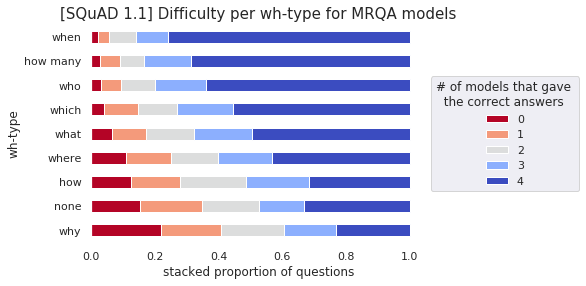

In [221]:
import pandas as pd
import seaborn as sns
import matplotlib
sns.set()

df = pd.DataFrame(ll, columns=['0', '1', '2', '3', '4'], 
                  index=tmp.index)
#df['unsolvable'] = -df['unsolvable']
ax = df.plot(title = '[SQuAD 1.1] Difficulty per wh-type for MRQA models', kind='barh', stacked=True, colormap='coolwarm_r')
ax.set_facecolor("w")
matplotlib.pyplot.ylabel('wh-type')
matplotlib.pyplot.xlabel('stacked proportion of questions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="# of models that gave \n  the correct answers")
ax.set_title('[SQuAD 1.1] Difficulty per wh-type for MRQA models', fontsize=15)

Text(0.5, 1.0, 'Difficulty per wh-type for MRQA models')

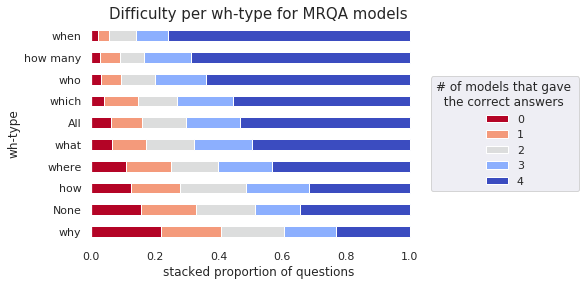

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib
sns.set()

df = pd.DataFrame(ll, columns=['0', '1', '2', '3', '4'], 
                  index=tmp.index)
#df['unsolvable'] = -df['unsolvable']
ax = df.plot(title = 'Difficulty per wh-type for MRQA models', kind='barh', stacked=True, colormap='coolwarm_r')
ax.set_facecolor("w")
matplotlib.pyplot.ylabel('wh-type')
matplotlib.pyplot.xlabel('stacked proportion of questions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="# of models that gave \n  the correct answers")
ax.set_title('Difficulty per wh-type for MRQA models', fontsize=15)

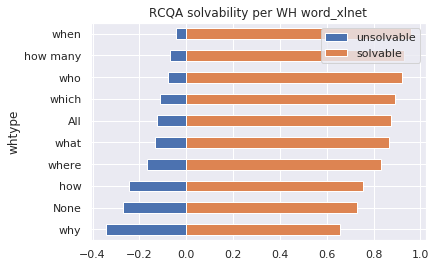

In [40]:
##  only xlnet
import pandas as pd
import seaborn as sns
sns.set()
df = pd.DataFrame(ll, columns=['unsolvable', 'solvable'], 
                  index=tmp.index)
df['unsolvable'] = -df['unsolvable']
df.plot(title = 'RCQA solvability per WH word_xlnet', kind='barh', stacked=True);

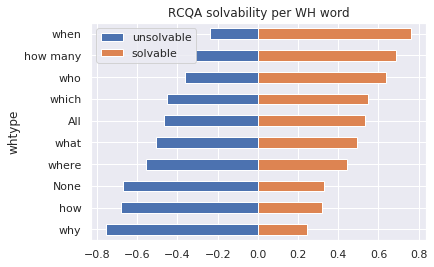

In [43]:
import pandas as pd
import seaborn as sns
sns.set()

df = pd.DataFrame(ll, columns=['unsolvable', 'solvable'], 
                  index=tmp.index)
df['unsolvable'] = -df['unsolvable']
df.plot(title = 'RCQA solvability per WH word', kind='barh', stacked=True);

## LAT type wrong probability

In [138]:
def PosTagger(sentence):    
    '''
    POS Tagger
    
    @return the tuple of token and POS tag in sentence
    '''
    doc = nlp(sentence)
    poslist = []

    for token in doc:
        poslist.append((token.text, token.tag_, token.pos_, token.lemma_))
    
    return poslist

In [142]:
def detailAnsType(question):
    '''
    Find detail answer type
    
    @return the detail answer type
    '''
    st = False
    ans = ''
    PTs = PosTagger(question)
    
    #print (PTs)
    
    for idx, w in enumerate(PTs):
        if w[0].lower() == 'what' or w[0].lower() == 'which':
            st = True
            continue
        #print(w)
        if st == True and (w[0].lower() == 'did' or w[0].lower() == 'does' or w[0].lower() == 'do' or w[0].lower() == 'can'): break
        if st == True and (w[2] == 'VERB' and w[3].lower() != 'be'): break
        if st == True and (w[1] == 'NN' or w[1] == 'NNP' or w[1] == 'NNS'):
            if 'kind' in w[0].lower() or 'name' in w[0].lower() or 'type' in w[0].lower() or (idx < len(PTs)-1 and "\'s" in PTs[idx+1][0].lower()):
                continue
                
            for j in range(idx, len(PTs)):
                if PTs[j][0][0].isupper():
                    ans = ''
                    break
                if not (PTs[j][1] == 'NN' or PTs[j][1] == 'NNP' or PTs[j][1] == 'NNS'):
                    if "\'s" in PTs[j][0].lower() or "s\'" in PTs[j][0].lower():
                        ans = ''
                        break
                    else: return (ans, PTs[j-1][0])
                ans += PTs[j][0]+' '
                
    
    return ("None","None")

In [143]:
detailAnsType('What shows us lost chloroplasts?')

('None', 'None')

In [168]:
lat_group = Counter()
lat_list = []

for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            question = clearquestion(qas['question'])
            
            lat_d, lat_s = detailAnsType(question)
            lat_list.append(lat_s)
            
            if lat_s == 'chloroplasts':
                print('chloroplasts: ', question)
                print('context: ', qas['context'])
                print('answer', qas['answers'][0]['text'])
    
            lat_group[lat_s] += 1

chloroplasts:  What are chloroplasts descended from?


KeyError: 'context'

In [145]:
qid_dict2 = {'qid': qid_list, 'whtype': whtype_list, 'lattype': lat_list, 'RC_solvable': RC_solvable_list, 'RC_solvable2': RC_solvable_list2, 'RC_solvable_count': RC_solvable_count}

In [42]:
len(lat_group)

1763

In [36]:
qid_dict2 = {'qid': qid_list, 'whtype': whtype_list, 'lattype': lat_list, 'xlnet_solvable': xlnet_solvable_list}

In [146]:
df2 = pd.DataFrame(qid_dict2)

In [147]:
df_filter = df2.loc[(df2['whtype'] == 'what') | (df2['whtype'] == 'which')]

In [41]:
len(df_filter.loc[(df2['lattype'] == 'None')])

1133

In [115]:
df_filter1 = df_filter.drop(columns=['whtype','RC_solvable2','RC_solvable_count'])
df_filter2 = df_filter.drop(columns=['whtype','RC_solvable','RC_solvable_count'])

In [148]:
df_filter_count = df_filter.drop(columns=['whtype','RC_solvable','RC_solvable2'])

In [48]:
df_filter_xlnet = df_filter.drop(columns=['whtype'])

In [59]:
tmp = df_filter.drop(columns=['whtype','RC_solvable','RC_solvable2','RC_solvable_count'])

In [41]:
latgroups = tmp.groupby(['lattype']).count()

In [42]:
lat_freq = dict()
for lat in latgroups.iterrows():
    
    lat_freq[lat[0]] = lat[1].qid

In [119]:
counts1 = df_filter1.groupby(['lattype','RC_solvable']).count()
counts2 = df_filter2.groupby(['lattype','RC_solvable2']).count()

In [149]:
counts_count = df_filter_count.groupby(['lattype','RC_solvable_count']).count()

In [150]:
df_filter_count

,qid,lattype,RC_solvable_count
0,56be4db0acb8001400a502ec,team,4
1,56be4db0acb8001400a502ed,team,2
3,56be4db0acb8001400a502ef,team,4
4,56be4db0acb8001400a502f0,color,3
5,56be8e613aeaaa14008c90d1,theme,0
...,...,...,...
10565,5737aafd1c456719005744fb,term,3
10566,5737aafd1c456719005744fc,kilogram,4
10567,5737aafd1c456719005744fd,None,4
10568,5737aafd1c456719005744fe,None,3


In [50]:
counts_xlnet = df_filter_xlnet.groupby(['lattype','xlnet_solvable']).count()

In [120]:
counts1 = counts1.unstack(level=1)
counts1.columns = counts1.columns.droplevel(level=0)

counts2 = counts2.unstack(level=1)
counts2.columns = counts2.columns.droplevel(level=0)

In [151]:
counts_count = counts_count.unstack(level=1)
counts_count.columns = counts_count.columns.droplevel(level=0)
print (counts_count)

RC_solvable_count      0      1      2      3      4
lattype                                             
%                    1.0    NaN    NaN    NaN    NaN
None               170.0  280.0  318.0  368.0  792.0
abbreviation         NaN    NaN    NaN    NaN    1.0
abilities            NaN    NaN    1.0    NaN    NaN
ability              NaN    1.0    NaN    NaN    NaN
...                  ...    ...    ...    ...    ...
writings             1.0    NaN    NaN    NaN    1.0
wustite              NaN    NaN    1.0    NaN    NaN
yards                NaN    NaN    NaN    NaN    1.0
year                 NaN    2.0    6.0   22.0  239.0
years                2.0    2.0    1.0    1.0    9.0

[1479 rows x 5 columns]


In [51]:
counts_xlnet = counts_xlnet.unstack(level=1)
counts_xlnet.columns = counts_xlnet.columns.droplevel(level=0)
print (counts_xlnet)

xlnet_solvable  False  True 
lattype                     
%                 1.0    NaN
-                 NaN    1.0
30th              NaN    1.0
A167              NaN    1.0
AAP               NaN    1.0
...               ...    ...
x.25              NaN    1.0
yards             NaN    1.0
year              4.0  267.0
years             3.0   13.0
zhèng             NaN    1.0

[2231 rows x 2 columns]


In [121]:
counts1 = counts1.fillna(0)
counts1['Total'] = counts1.sum(axis=1)

In [122]:
counts2 = counts2.fillna(0)
counts2['Total'] = counts2.sum(axis=1)

In [152]:
counts_count = counts_count.fillna(0)
counts_count['Total'] = counts_count.sum(axis=1)

In [52]:
counts_xlnet = counts_xlnet.fillna(0)
counts_xlnet['Total'] = counts_xlnet.sum(axis=1)

In [153]:
#counts1 = counts1.sort_values(['Total'], ascending=[0])
#counts2 = counts2.sort_values(['Total'], ascending=[0])
counts_count = counts_count.sort_values(['Total'], ascending=[0])
#counts_xlnet = counts_xlnet.sort_values(['Total'], ascending=[0])

In [154]:
counts_count

RC_solvable_count,0,1,2,3,4,Total
lattype,,,,,,
None,170.0,280.0,318.0,368.0,792.0,1928.0
year,0.0,2.0,6.0,22.0,239.0,269.0
company,3.0,7.0,7.0,9.0,50.0,76.0
country,2.0,7.0,4.0,8.0,53.0,74.0
city,1.0,0.0,3.0,7.0,51.0,62.0
...,...,...,...,...,...,...
ideals,0.0,0.0,0.0,0.0,1.0,1.0
identifies,0.0,0.0,0.0,1.0,0.0,1.0
idiom,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
## [todo] weighted sum bw 0~4 models

In [92]:
count_check = list(counts_count.Total)

c = list(filter(lambda x: x >= 20, count_check))

In [93]:
len(c)

39

In [124]:
result_sample_alo = counts1.head(100) #at leat one
result_sample_all = counts2.head(100) # all

In [155]:
result_sample_count = counts_count.head(100)

In [56]:
result_sample_xlnet = counts_xlnet.head(100)

In [56]:
result_sample_count.keys()

Index([0, 1, 2, 3, 4, 'Total'], dtype='object', name='RC_solvable_count')

In [156]:
for i in range(5):
    result_sample_count[i] = result_sample_count[i]/result_sample_count['Total']

/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
result_sample_count

RC_solvable_count,0,1,2,3,4,Total
lattype,,,,,,
None,0.085613,0.149162,0.166814,0.184466,0.413945,1133.0
year,0.000000,0.007380,0.022140,0.088561,0.881919,271.0
company,0.037500,0.087500,0.087500,0.137500,0.650000,80.0
country,0.027027,0.094595,0.054054,0.108108,0.716216,74.0
city,0.015385,0.000000,0.061538,0.107692,0.815385,65.0
...,...,...,...,...,...,...
teachers,0.000000,0.100000,0.400000,0.500000,0.000000,10.0
forces,0.000000,0.000000,0.000000,0.300000,0.700000,10.0
movement,0.000000,0.100000,0.200000,0.400000,0.300000,10.0


In [157]:
## 1, 0.5, 0.25

import numpy as np

urgent_list = []
wrong_score_list = []
freq_list = []
freq_log_list = []
for lat, instance in result_sample_count.iterrows():    
    wrong_score = instance[0]+0.5*instance[1]+0.25*instance[2]
    freq_log = np.log(instance['Total'])
    freq = instance['Total']
    
    wrong_score_list.append(wrong_score)
    freq_list.append(int(freq))
    freq_log_list.append(freq_log)
    
    urgent = wrong_score*freq
    urgent_list.append(urgent)

In [158]:
result_sample_count['freq'] = freq_list
result_sample_count['freq_log'] = freq_log_list
result_sample_count['wrong_score'] = wrong_score_list
result_sample_count['urgent'] = urgent_list

/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [88]:
result_sample_count

RC_solvable_count,0,1,2,3,4,Total,freq,freq_log,wrong_score,urgent
lattype,,,,,,,,,,
None,0.085613,0.149162,0.166814,0.184466,0.413945,1133.0,1133,7.032624,0.201898,228.75
year,0.000000,0.007380,0.022140,0.088561,0.881919,271.0,271,5.602119,0.009225,2.50
company,0.037500,0.087500,0.087500,0.137500,0.650000,80.0,80,4.382027,0.103125,8.25
country,0.027027,0.094595,0.054054,0.108108,0.716216,74.0,74,4.304065,0.087838,6.50
city,0.015385,0.000000,0.061538,0.107692,0.815385,65.0,65,4.174387,0.030769,2.00
...,...,...,...,...,...,...,...,...,...,...
teachers,0.000000,0.100000,0.400000,0.500000,0.000000,10.0,10,2.302585,0.150000,1.50
forces,0.000000,0.000000,0.000000,0.300000,0.700000,10.0,10,2.302585,0.000000,0.00
movement,0.000000,0.100000,0.200000,0.400000,0.300000,10.0,10,2.302585,0.100000,1.00


In [83]:
import pickle
f = open('sqaud_1.1_lat_table','wb')
pickle.dump(result_sample_count, f)

In [84]:
result_sample_count = result_sample_count.sort_values(['urgent'], ascending=[0])

KeyError: 'urgent'

In [66]:
tmp = result_sample_count.copy(deep = True)

In [67]:
roundtmp = tmp.round(decimals=3)

In [68]:
roundtmp

RC_solvable_count,0,1,2,3,4,Total,freq,freq_log,wrong_score,urgent
lattype,,,,,,,,,,
None,0.086,0.149,0.167,0.184,0.414,1133.0,1133,7.033,0.202,228.75
chloroplasts,0.200,0.100,0.367,0.033,0.300,30.0,30,3.401,0.342,10.25
company,0.038,0.088,0.088,0.138,0.650,80.0,80,4.382,0.103,8.25
system,0.128,0.026,0.154,0.205,0.487,39.0,39,3.664,0.179,7.00
part,0.083,0.083,0.278,0.111,0.444,36.0,36,3.584,0.194,7.00
...,...,...,...,...,...,...,...,...,...,...
service,0.000,0.000,0.071,0.286,0.643,14.0,14,2.639,0.018,0.25
nationality,0.000,0.000,0.000,0.000,1.000,12.0,12,2.485,0.000,0.00
cost,0.000,0.000,0.000,0.000,1.000,10.0,10,2.303,0.000,0.00


In [69]:
result_sample_alo['ratio'] = result_sample_alo[False]/result_sample_alo['Total']
result_sample_all['ratio'] = result_sample_all[False]/result_sample_all['Total']

NameError: name 'result_sample_alo' is not defined

In [70]:
result_sample_xlnet['ratio'] = result_sample_xlnet[False]/result_sample_xlnet['Total']

NameError: name 'result_sample_xlnet' is not defined

In [126]:
result_sample_alo = result_sample_alo.sort_values(['ratio'], ascending=[0])
result_sample_all = result_sample_all.sort_values(['ratio'], ascending=[0])

In [127]:
result_sample_alo.columns = ['False','True','Total','Ratio']
result_sample_all.columns = ['False','True','Total','Ratio']

In [58]:
result_sample_xlnet = result_sample_xlnet.sort_values(['ratio'], ascending=[0])
result_sample_xlnet.columns = ['False','True','Total','Ratio']

In [159]:
result_sample_count.columns = ['0','1','2','3','4','Total','freq','freq_log','wrong_score','urgent']

In [160]:
result_sample_count['score'] = result_sample_count['4']+0.5*result_sample_count['3']-0.5*result_sample_count['1']-result_sample_count['0']

/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [165]:
result_sample_count = result_sample_count.sort_values(['score'], ascending=[1])

In [166]:
result_sample_count.index

Index(['impact', 'chloroplasts', 'point', 'reason', 'goal', 'dynasty',
       'function', 'way', 'role', 'effect', 'event', 'division', 'amount',
       'body', 'areas', 'schools', 'line', 'shape', 'field', 'compounds',
       'None', 'time', 'part', 'color', 'title', 'system', 'example', 'region',
       'leader', 'show', 'form', 'law', 'years', 'program', 'series', 'sort',
       'purpose', 'feature', 'engines', 'concept', 'episode', 'group', 'team',
       'force', 'class', 'period', 'groups', 'movement', 'cells', 'teacher',
       'examples', 'position', 'number', 'day', 'problem', 'percentage',
       'rate', 'area', 'month', 'district', 'state', 'entity', 'term', 'book',
       'company', 'sources', 'theorem', 'network', 'artist', 'language',
       'organization', 'molecules', 'century', 'station', 'work', 'river',
       'country', 'population', 'venue', 'church', 'religion', 'process',
       'word', 'theory', 'direction', 'decade', 'countries', 'service',
       'player', 'wa

In [109]:
result_sample_xlnet['False'] /= result_sample_xlnet['Total']
result_sample_xlnet['True'] /= result_sample_xlnet['Total']

NameError: name 'result_sample_xlnet' is not defined

In [128]:
result_sample_alo['False'] /= result_sample_alo['Total']
result_sample_alo['True'] /= result_sample_alo['Total']

result_sample_all['False'] /= result_sample_all['Total']
result_sample_all['True'] /= result_sample_all['Total']

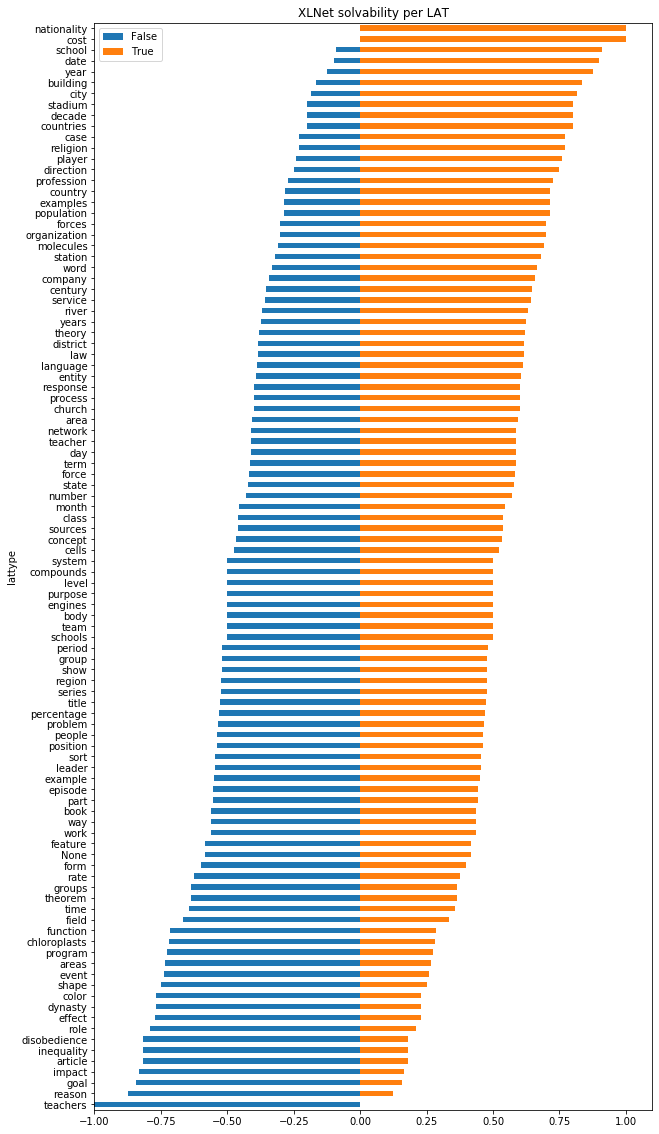

In [129]:
result_sample_alo = result_sample_alo[['False','True']]
result_sample_alo['False'] = -result_sample_alo['False']
result_sample_alo.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'XLNet solvability per LAT')

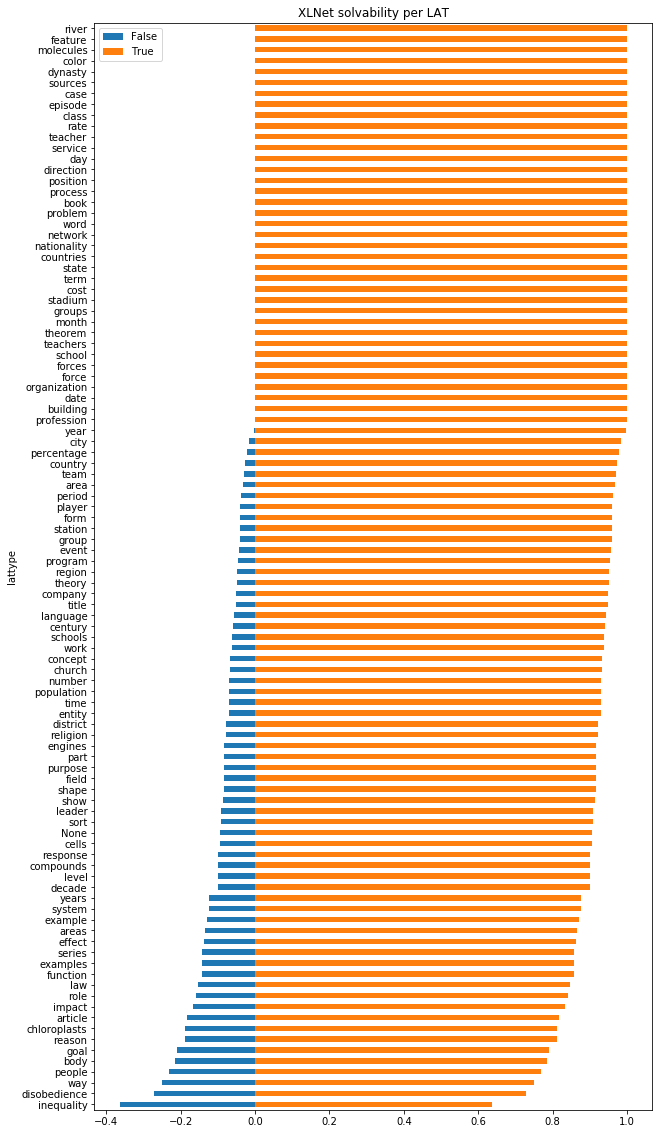

In [130]:
result_sample_all = result_sample_all[['False','True']]
result_sample_all['False'] = -result_sample_all['False']
result_sample_all.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'XLNet solvability per LAT')

/home/doyeon/anaconda3/envs/kcc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


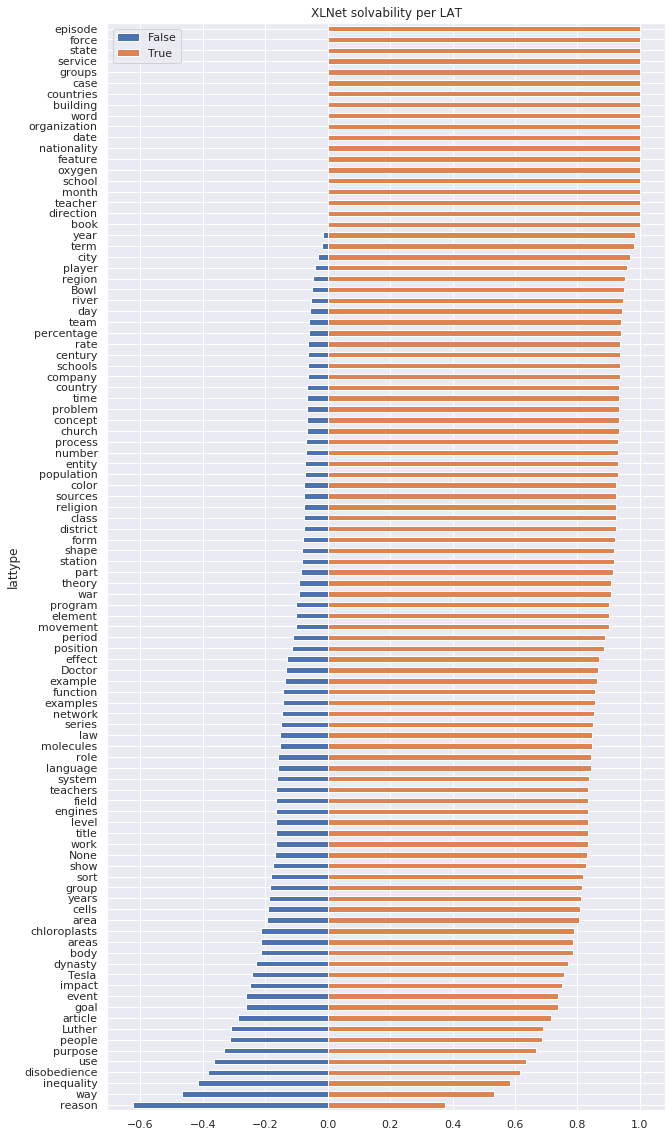

In [62]:
result_sample_xlnet = result_sample_xlnet[['False','True']]
result_sample_xlnet['False'] = -result_sample_xlnet['False']
result_sample_xlnet.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'XLNet solvability per LAT')

Text(0.5, 1.0, '[SQuAD 1.1] Difficulty per LAT type for MRQA models')

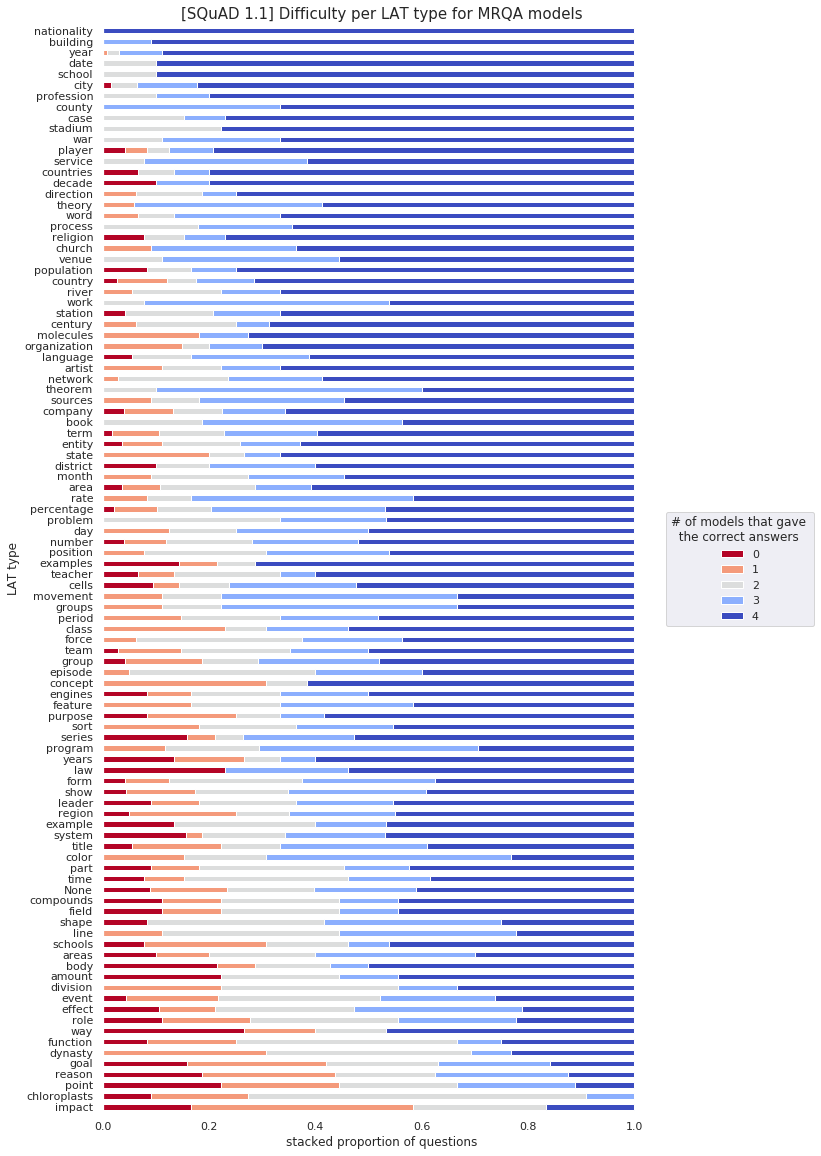

In [167]:
import matplotlib

result_sample_count = result_sample_count[['0','1','2','3','4']]
#result_sample_alo['False'] = -result_sample_alo['False']
ax = result_sample_count.plot(figsize=(10,20), kind='barh', stacked=True , colormap='coolwarm_r')

ax.set_facecolor("w")
matplotlib.pyplot.ylabel('LAT type')
matplotlib.pyplot.xlabel('stacked proportion of questions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="# of models that gave \n  the correct answers")
ax.set_title('[SQuAD 1.1] Difficulty per LAT type for MRQA models', fontsize=15)

In [194]:
result_sample_alo = result_sample_alo[['False','True']]
result_sample_alo['False'] = -result_sample_alo['False']
result_sample_alo.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'RC solvability per LAT')

KeyError: "None of [Index(['False', 'True'], dtype='object', name='RC_solvable')] are in the [columns]"

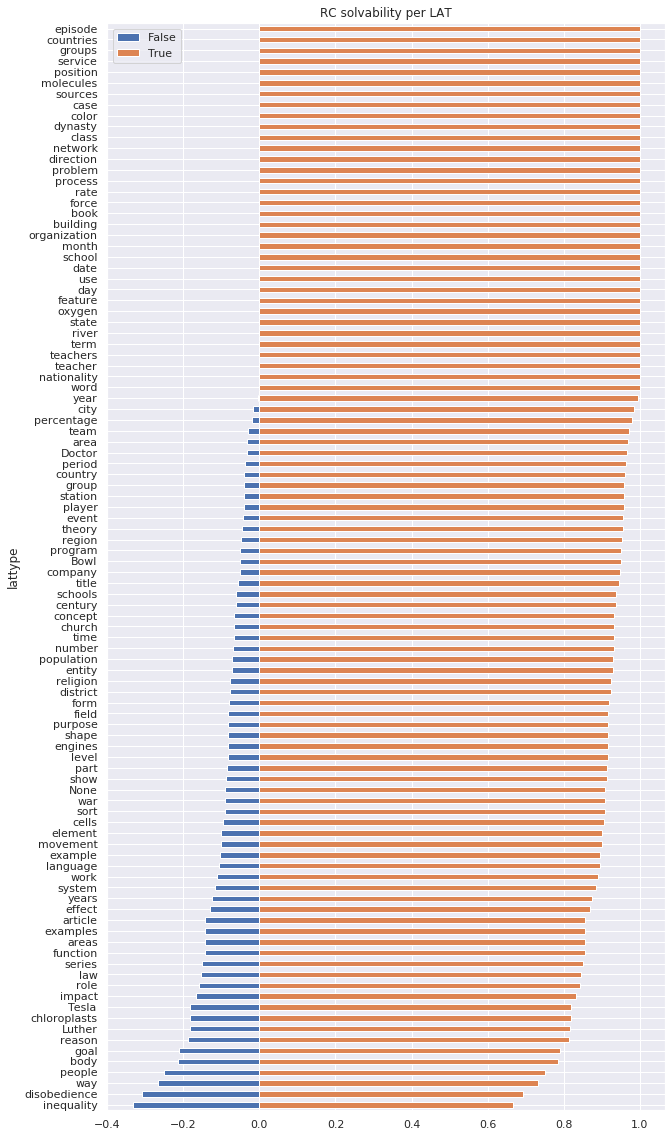

In [127]:
result_sample_all = result_sample_all[['False','True']]
result_sample_all['False'] = -result_sample_all['False']
result_sample_all.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'RC solvability per LAT')

In [173]:
pd.DataFrame(rand(10, 4))

,0,1,2,3
0,0.070429,0.314044,0.198377,0.046965
1,0.749975,0.313324,0.588196,0.009443
2,0.048844,0.023699,0.762604,0.092510
3,0.564028,0.023477,0.137801,0.141642
4,0.378162,0.212360,0.256653,0.705599
5,0.041651,0.066077,0.120181,0.473346
6,0.256582,0.133719,0.114964,0.538792
7,0.220245,0.159481,0.318749,0.242615
8,0.503184,0.947943,0.611468,0.419353
9,0.440137,0.689202,0.118517,0.299765


In [237]:
PosTagger("a,b,c,d or e is alphabet")

[('a', 'DT'),
 (',', ','),
 ('b', 'NN'),
 (',', ','),
 ('c', 'NN'),
 (',', ','),
 ('d', 'NN'),
 ('or', 'CC'),
 ('e', 'NN'),
 ('is', 'VBZ'),
 ('alphabet', 'JJ')]

## NN list check

In [239]:
entity_list_qid = []
for instance in tqdm_notebook(dev):
    
    question = clearquestion(instance['Question'])
    pos_list = PosTagger(question)
    
    posstr = ""
    for word, pos in pos_list:
        posstr += pos
    
    if ('NNCCNN' in posstr) or ('NN,NN' in posstr): 
        entity_list_qid.append(instance['QuestionId'])

In [244]:
len(set(entity_list_qid) & rc_wrong) / len(set(entity_list_qid))

0.5345345345345346

In [358]:
 len(set(entity_list_qid))

333

## qualitative analysis

### four failure case

In [88]:
aaa = "'5728e8212ca10214002daa6f	56e1bc3ae3433e1400423107	5726e179dd62a815002e93b0	573060b48ab72b1400f9c4c7	5725c0f289a1e219009abdf2	570d4e6cb3d812140066d671	572fc8a904bcaa1900d76d21	57060a6e52bb8914006897fa	572864542ca10214002da2e2	57263ea0271a42140099d7c4	571ce9bddd7acb1400e4c1a1'"

In [89]:
ns = "','".join(aaa.split("\t"))
ns

"'5728e8212ca10214002daa6f','56e1bc3ae3433e1400423107','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572fc8a904bcaa1900d76d21','57060a6e52bb8914006897fa','572864542ca10214002da2e2','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1'"

In [2]:
at_lat_clear = ['5726534d708984140094c26e','570d4030fed7b91900d45da3','56e1e9dfe3433e14004231fe','57302bd0b2c2fd14005689dc','57264e455951b619008f6f65','571098f8a58dae1900cd6ab2','57060a6e52bb8914006897fa']
at_lat_abstract = ['56e1bc3ae3433e1400423107','5728e8212ca10214002daa6f','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','571ce9bddd7acb1400e4c1a1']
at_wh_clear = ['572fc8a904bcaa1900d76d21','57286dfa2ca10214002da332']
at_wh_abstract = ['572691545951b619008f76e3','570d4e6cb3d812140066d671','572864542ca10214002da2e2']
nonat = ['5725c0f289a1e219009abdf2','5727ff083acd2414000df1ae','57263ea0271a42140099d7c4']

short = ['56e1bc3ae3433e1400423107','570d4030fed7b91900d45da3','56e1e9dfe3433e14004231fe','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','57302bd0b2c2fd14005689dc','57264e455951b619008f6f65','571098f8a58dae1900cd6ab2','572fc8a904bcaa1900d76d21','57060a6e52bb8914006897fa','5727ff083acd2414000df1ae']
explain = ['5726534d708984140094c26e','5728e8212ca10214002daa6f','572691545951b619008f76e3','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572864542ca10214002da2e2','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1']

alias = ['5728e8212ca10214002daa6f','570d4030fed7b91900d45da3','57264e455951b619008f6f65','572691545951b619008f76e3','5725c0f289a1e219009abdf2','571098f8a58dae1900cd6ab2','572fc8a904bcaa1900d76d21','572864542ca10214002da2e2']
boundary = ['5726534d708984140094c26e','5728e8212ca10214002daa6f','56e1bc3ae3433e1400423107','56e1e9dfe3433e14004231fe','573060b48ab72b1400f9c4c7','57302bd0b2c2fd14005689dc','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572fc8a904bcaa1900d76d21','5727ff083acd2414000df1ae','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1']
wrong_context = ['5728e8212ca10214002daa6f','56e1bc3ae3433e1400423107','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572fc8a904bcaa1900d76d21','57060a6e52bb8914006897fa','572864542ca10214002da2e2','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1']
at_wrong = []
modifier = ['57286dfa2ca10214002da332']


In [3]:
at_lat_clear = set(at_lat_clear)
at_lat_abstract = set(at_lat_abstract)
at_wh_clear = set(at_wh_clear)
at_wh_abstract = set(at_wh_abstract)
nonat = set(nonat)

short = set(short)
explain = set(explain)

alias = set(alias)
boundary = set(boundary)
wrong_context = set(wrong_context)
at_wrong = set(at_wrong)
modifier = set(modifier)

In [4]:
at_lat_clear & short

{'56e1e9dfe3433e14004231fe',
 '57060a6e52bb8914006897fa',
 '570d4030fed7b91900d45da3',
 '571098f8a58dae1900cd6ab2',
 '57264e455951b619008f6f65',
 '57302bd0b2c2fd14005689dc'}

In [5]:
at_lat_clear & explain

{'5726534d708984140094c26e'}

In [11]:
## query type
print ("lat clear: {}, lat abstract: {}, wh clear: {}, wh abstract: {}, Non AT: {} ".format(len(at_lat_clear), len(at_lat_abstract), len(at_wh_clear), len(at_wh_abstract), len(nonat)))

lat clear: 7, lat abstract: 5, wh clear: 2, wh abstract: 3, Non AT: 3 


In [6]:
## LAT clear
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_lat_clear&alias), len(at_lat_clear&alias), len(at_lat_clear&boundary), len(at_lat_clear&at_wrong), len(at_lat_clear&modifier)))

alias: 3, boundary: 3, wrong context: 3, AT wrong: 0, modifier: 0 


In [7]:
## LAT abstract
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_lat_abstract&alias), len(at_lat_abstract&alias), len(at_lat_abstract&boundary), len(at_lat_abstract&at_wrong), len(at_lat_abstract&modifier)))

alias: 1, boundary: 1, wrong context: 4, AT wrong: 0, modifier: 0 


In [8]:
## WH clear
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_wh_clear&alias), len(at_wh_clear&alias), len(at_wh_clear&boundary), len(at_wh_clear&at_wrong), len(at_wh_clear&modifier)))

alias: 1, boundary: 1, wrong context: 1, AT wrong: 0, modifier: 1 


In [9]:
## WH abstract
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_wh_abstract&alias), len(at_wh_abstract&alias), len(at_wh_abstract&boundary), len(at_wh_abstract&at_wrong), len(at_wh_abstract&modifier)))

alias: 2, boundary: 2, wrong context: 1, AT wrong: 0, modifier: 0 


In [10]:
## Non AT 
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(nonat&alias), len(nonat&alias), len(nonat&boundary), len(nonat&at_wrong), len(nonat&modifier)))

alias: 1, boundary: 1, wrong context: 3, AT wrong: 0, modifier: 0 
